# Method Outline
We analyse the spontaneous emission (SE) rate of the EDTS layer in air and covered with water, denoted $a$ and $w$, respectively. Observing that that the SE rates calculated from PL measurements, $\Gamma^{a,w} \equiv 1/\tau^{a,w}$, are composed of radiative, $\Gamma_{rad}$, and non-radiative, $\Gamma_{nrad}$, components gives

$$
\begin{align}
\Gamma^a &= \Gamma^a_{rad} + \Gamma^a_{nrad} \,,\\
\Gamma^w &= \Gamma^w_{rad} + \Gamma^w_{nrad} \approx \beta^w_a\Gamma^a_{rad} + \Gamma^a_{nrad}
\end{align}
$$

where $\beta^w_a = \Gamma^w_{rad}/\Gamma^a_{rad}$ is the theoretical radiative decay rate ratio and $\Gamma^a_{nrad} \approx \Gamma^w_{nrad}$ is assumed. The latter is justified as the non-radiative recombination processes in SiO$_2$ are due to short-range Forster energy transfer between the Er$^{3+}$ transition and the resonant hydroxyl groups, which are therefore not dependent on the external surrounding environment of the EDTS layer.

Rewritten in matrix form this gives:

$$
\begin{bmatrix}
    \Gamma^a \\
    \Gamma^w \\
\end{bmatrix}
=
\begin{bmatrix}
            1 & 1\\
    \beta^w_a & 1 \\
\end{bmatrix}
\begin{bmatrix}
    \Gamma^a_{rad} \\
    \Gamma^a_{nrad} \\
\end{bmatrix} \,.
$$

The unknown radiative and non-radiative decay rates (in air) are therefore evaluated by solving

$$\begin{bmatrix}
    \Gamma^a_{rad} \\
    \Gamma^a_{nrad} \\
\end{bmatrix}
=
\begin{bmatrix}
            1 & 1\\
    \beta^w_a & 1 \\
\end{bmatrix}^{-1}
\begin{bmatrix}
    \Gamma^a \\
    \Gamma^w \\
\end{bmatrix}
$$

The Quantum efficiency (q) is given by

$$
\begin{equation}
q^x = \frac{\Gamma^x_{rad}}{\Gamma^x_{rad} + \Gamma_{nrad}} \left(= \frac{\tau^x_{mes}}{\tau^x_{rad}}\right) \,,
\end{equation}
$$

and is therefore dependent on the medium ($x=a,w$) surrounding the EDTS layer.

In [1]:
# Import scientific and plotting libraries
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

In [ ]:
# Set figure size
WIDTH = 246.0  # the number (in pt) latex spits out when typing: \the\linewidth  
FACTOR = 0.9   # the fraction of the width you'd like the figure to occupy  
fig_width_pt  = WIDTH * FACTOR

inches_per_pt = 1.0 / 72.27  
golden_ratio  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good

fig_width_in  = fig_width_pt * inches_per_pt  # figure width in inches  
fig_height_in = fig_width_in * golden_ratio   # figure height in inches  
fig_dims    = [fig_width_in, fig_height_in] # fig dims as a list

# Update rcParams for figure size
params = {
    'font.size'       : 9.0,
    'text.usetex'     : True,
    'savefig.dpi'     : 1200,
    'savefig.format'  : 'pdf',
    'savefig.bbox'    : 'tight',
    'figure.figsize'  : fig_dims,
   }
plt.rcParams.update(params)

## Theoretical radiative decay rate ($\beta$)
First calculate the radiative SE rate from theory for the layer covered in air and water (region between the dashed vertical lines): 

In [2]:
from IPython.display import IFrame
IFrame("./T2_purcell_factor_total.pdf", width=900, height=300)

The Er ions are (approximately) evenly distributed throughout the layer so take an average decay rate over the layer for both structures. From the graph above we get $\beta^w_a = \Gamma^w_{rad}/\Gamma^a_{rad} = 1.076$. We can therefore write down the matrix:

In [2]:
beta = 1.076  # Theoretical SE ratio (Gamma_rad: w/a=water/air) (1.076 inc. waveguiding and 1.014 without waveguiding)
beta = 1.13198 # Air - Glycerol
matrix = np.array([[1, 1], [beta, 1]])
matrix

array([[ 1.     ,  1.     ],
       [ 1.13198,  1.     ]])

and hence also the inverse of the matrix

In [3]:
# Invert matrix
inv = np.linalg.inv(matrix)
inv

array([[-7.57690559,  7.57690559],
       [ 8.57690559, -7.57690559]])

## Measured Decay Rates
First plot and fit decays - rejecting the pump time data:

In [4]:
# Lifetime fitting helper functions
def model_func(t, a, tau, c):
    """ Model function for a monoexponential decay.
    """
    return a*np.exp(-t/tau)+c

def fit_decay(t, y):
    """ Fit the model monoexponential decay with input data.
        t: time
        y: intensity
        return: [a, tau c]
    """
    from scipy.optimize import curve_fit
    
    try:
        guess = [max(y), 10, min(y)]  # Guess for initial parameters a, tau, c
        popt, pcov = curve_fit(model_func, t, y, guess)
        return popt
    except:
        print('Did not fit a single exp :(')

<IPython.core.display.Javascript object>


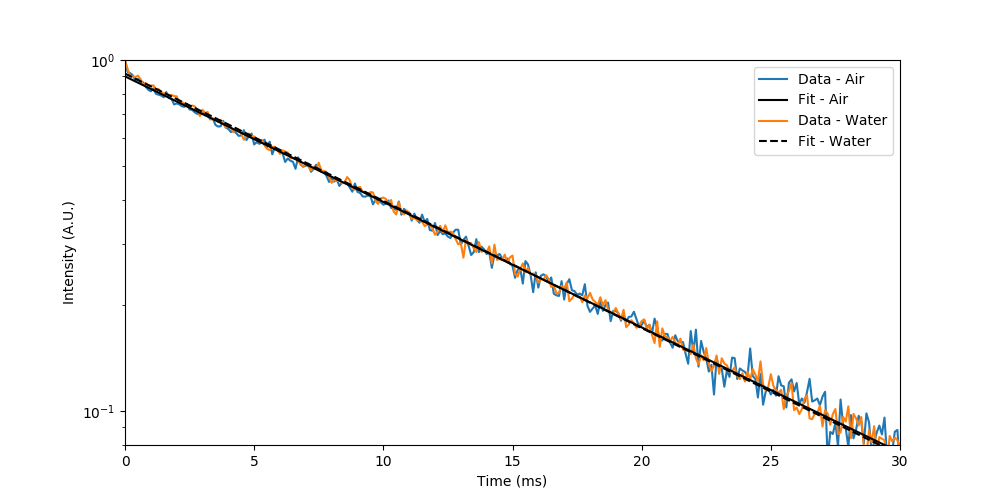

Air lifetime is 12.12 ms
Water lifetime is 11.97 ms


In [6]:
#########################################################
# Air Lifetime Data
pump = 1      # Pump time (ms)
reject = 0  # Additional reject time (ms)
file = './Air (400mA 1ms).txt'  # File name with lifetime data

# Load data
data = np.genfromtxt(fname=file, delimiter=',', dtype=float, skip_header=11, usecols=(0,1))
time = data[:,0]/1E6   # Convert time from ns to ms
decay = data[:,1]

# Drop the data while pump on - *!required for lifetime fitting*!
time -= pump           # Shift time axis to account for the pump
ind = np.where(time>=0)
time = time[ind]
decay = decay[ind]

# Prepare y data
ind = np.where(time>=90)
decay -= np.mean(decay[ind])    # Subtract background noise (avg. of tail last 10ms)
decay /= decay[0] # max(decay)    # Normalise

# Fit the data and get the lifetime
popt = fit_decay(time, decay)
tau_a = popt[1]

# Simulate data with fitting parameters
y_fit = model_func(time, popt[0], tau_a, popt[2])

# Plot data and fit
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(time, decay, label='Data - Air', zorder=-1)
ax.plot(time, y_fit, 'k', label='Fit - Air', zorder=1)
print('Air lifetime is {0:.2f} ms'.format(tau_a))

##########################################################
## Water Lifetime Data
file = './Water (400mA 1ms).txt'  # File name with lifetime data

# Load data
data = np.genfromtxt(fname=file, delimiter=',', dtype=float, skip_header=11, usecols=(0,1))
time = data[:,0]/1E6   # Convert time from ns to ms
decay = data[:,1]

# Drop the data while pump on - *!required for lifetime fitting*!
time -= pump          # Shift time axis to account for the pump
ind = np.where(time>=0)
time = time[ind]
decay = decay[ind]

# Prepare y data
ind = np.where(time>=90)
decay -= np.mean(decay[ind])    # Subtract background noise (avg. of tail last 10ms)
decay /= decay[0] # max(decay)    # Normalise

# Fit the data and get the lifetime
popt = fit_decay(time, decay)
tau_w = popt[1]
print('Water lifetime is {0:.2f} ms'.format(tau_w))

# Simulate data with fitting parameters
y_fit = model_func(time, popt[0], tau_w, popt[2])

# Plot data and fit
ax.plot(time, decay, label='Data - Water', zorder=-1)
ax.plot(time, y_fit, 'k--', label='Fit - Water', zorder=1)

ax.set_yscale('log')
plt.ylim(0.08, 1)
plt.xlim(0, 30)
plt.xlabel('Time (ms)')
plt.ylabel('Intensity (A.U.)')
plt.legend()

With these lifetimes we can now evaluate the RHS array containing the total decay rates ($\Gamma^{a,w} \equiv 1/\tau^{a,w}$):

In [41]:
tau_a = 12.37510185
tau_w = 12.2115586

In [42]:
rhs = 1e3*np.array([[1/tau_a], [1/tau_w]])
rhs

array([[ 80.80741574],
       [ 81.88962873]])

## Solve rad and nrad components

In [43]:
# Solve radiative and non-radiative decay rates
lhs = inv @ rhs
rad = lhs[0][0]
nrad = lhs[1][0]

print('Radiative decay rate    : {:.2f} /s'.format(rad))
print('Non-radiative decay rate: {:.2f} /s \n'.format(nrad))

print('Radiative lifetime      : {:.3f} ms'.format(1e3/rad))
print('Non-radiative lifetime  : {:.3f} ms'.format(1e3/nrad))

Radiative decay rate    : 8.20 /s
Non-radiative decay rate: 72.61 /s 

Radiative lifetime      : 121.954 ms
Non-radiative lifetime  : 13.773 ms


## Solve the quantum efficiency (in air), q$^a$

In [45]:
q = rad / (rad + nrad)
print('Quantum Efficiency is {:.3%}'.format(q))

Quantum Efficiency is 10.147%


Using different beta values:

| Parameter       | Pol   | RAD + WG | RAD   |
|-----------------|-------|----------|-------|
|  $\beta$        | 1.026 | 1.076    | 1.014 |
|  $\gamma_{rad}$ | 41.5  | 14.2     | 77.06 |
| $\gamma_{nrad}$ | 41    | 68       | 5.43  |
| q               | 0.5   | 0.172    | 0.934 |